In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, asin, sqrt
from dateutil import parser
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import mlflow.sklearn

# plot settings
sns.set(style='whitegrid')

# file paths
DATA_RAW = "data/amazon_delivery.csv"
DATA_PROCESSED = "data/processed_amazon_delivery.csv"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [2]:
# Cell 2: helper functions

def haversine(lon1, lat1, lon2, lat2):
    """Great-circle distance in km between two (lon,lat) points."""
    if pd.isna(lon1) or pd.isna(lat1) or pd.isna(lon2) or pd.isna(lat2):
        return np.nan
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c

def parse_datetime(date_val, time_val=None):
    """Parse date and optional time to pandas.Timestamp. Returns NaT on failure."""
    try:
        if pd.isna(date_val) and pd.isna(time_val):
            return pd.NaT
        if pd.isna(time_val):
            return parser.parse(str(date_val))
        return parser.parse(f"{date_val} {time_val}")
    except Exception:
        return pd.NaT

def compute_time_difference_hours(t1, t2):
    """t1, t2: timestamps (or parseable). returns hours (float) or np.nan"""
    try:
        if pd.isna(t1) or pd.isna(t2):
            return np.nan
        td = pd.to_datetime(t2) - pd.to_datetime(t1)
        return td.total_seconds() / 3600.0
    except Exception:
        return np.nan

def to_lower_strip(series):
    return series.astype(str).str.strip().str.lower().replace({'nan': np.nan})


In [4]:
# Cell 3: load dataset and inspect
if not os.path.exists(DATA_RAW):
    raise FileNotFoundError(f"Put your dataset at {DATA_RAW}")

df = pd.read_csv(DATA_RAW)
print("Raw shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())

Raw shape: (43739, 16)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys



Columns: ['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery_Time', 'Category']


In [7]:
# Cell 4: cleaning & feature engineering
df = df.copy()

# drop exact duplicates
df = df.drop_duplicates().reset_index(drop=True)

# ensure coordinate columns are numeric if present
coord_cols = ['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']
for c in coord_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# compute distance_km if coords exist
if all(c in df.columns for c in ['Store_Longitude','Store_Latitude','Drop_Longitude','Drop_Latitude']):
    df['distance_km'] = df.apply(lambda r: haversine(
        r['Store_Longitude'], r['Store_Latitude'], r['Drop_Longitude'], r['Drop_Latitude']), axis=1)
else:
    df['distance_km'] = np.nan
    print("Coordinate columns missing; distance_km set to NaN. If you have lat/lon, rename columns to standard names.")

# parse timestamps (robust)
df['order_ts'] = df.apply(lambda r: parse_datetime(r.get('Order_Date', np.nan), r.get('Order_Time', np.nan)), axis=1)
df['pickup_ts'] = df.apply(lambda r: parse_datetime(r.get('Order_Date', np.nan), r.get('Pickup_Time', np.nan)), axis=1)

# time features
df['order_hour'] = df['order_ts'].dt.hour
df['order_dayofweek'] = df['order_ts'].dt.dayofweek
df['pickup_hour'] = df['pickup_ts'].dt.hour
df['order_to_pickup_hours'] = df.apply(lambda r: compute_time_difference_hours(r['order_ts'], r['pickup_ts']), axis=1)

# ensure target is numeric
if 'Delivery_Time' in df.columns:
    df['Delivery_Time'] = pd.to_numeric(df['Delivery_Time'], errors='coerce')
else:
    raise KeyError("Your dataset must have a 'Delivery_Time' column (target).")

# standardize categorical text columns if present
for c in ['Weather','Traffic','Vehicle','Area','Category']:
    if c in df.columns:
        df[c] = to_lower_strip(df[c])

# remove rows without target
df = df[df['Delivery_Time'].notna()].reset_index(drop=True)

# optionally drop rows missing critical features
req_cols = ['distance_km','order_ts','pickup_ts','Delivery_Time']
missing_req = df[req_cols].isna().any(axis=1).sum()
print(f"Rows missing any of {req_cols}: {missing_req}")
# For modeling we will drop rows missing distance or time features:
df = df.dropna(subset=['Delivery_Time']).reset_index(drop=True)

# Save processed data
df.to_csv(DATA_PROCESSED, index=False)
print("Processed saved to:", DATA_PROCESSED)
print("Processed shape:", df.shape)
display(df.head())


Rows missing any of ['distance_km', 'order_ts', 'pickup_ts', 'Delivery_Time']: 91
Processed saved to: data/processed_amazon_delivery.csv
Processed shape: (43739, 23)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,...,Area,Delivery_Time,Category,distance_km,order_ts,pickup_ts,order_hour,order_dayofweek,pickup_hour,order_to_pickup_hours
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,...,urban,120,clothing,3.025149,2022-03-19 11:30:00,2022-03-19 11:45:00,11.0,5.0,11,0.250000
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,...,metropolitian,165,electronics,20.183530,2022-03-25 19:45:00,2022-03-25 19:50:00,19.0,4.0,19,0.083333
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,...,urban,130,sports,1.552758,2022-03-19 08:30:00,2022-03-19 08:45:00,8.0,5.0,8,0.250000
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,...,metropolitian,105,cosmetics,7.790401,2022-04-05 18:00:00,2022-04-05 18:10:00,18.0,1.0,18,0.166667
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,...,metropolitian,150,toys,6.210138,2022-03-26 13:30:00,2022-03-26 13:45:00,13.0,5.0,13,0.250000


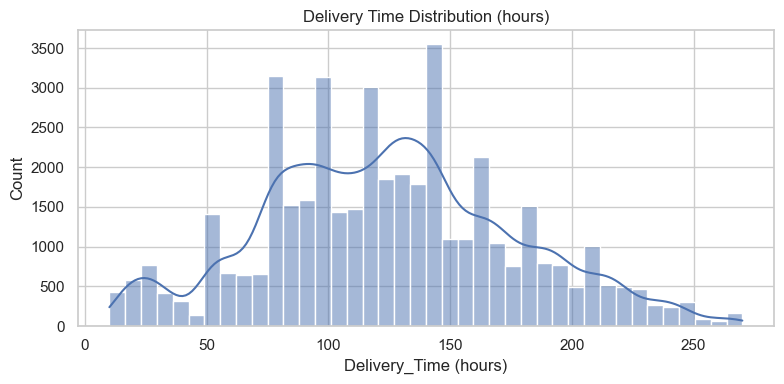

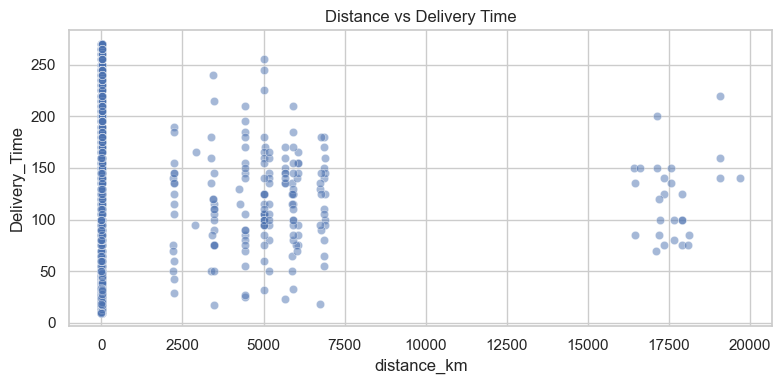

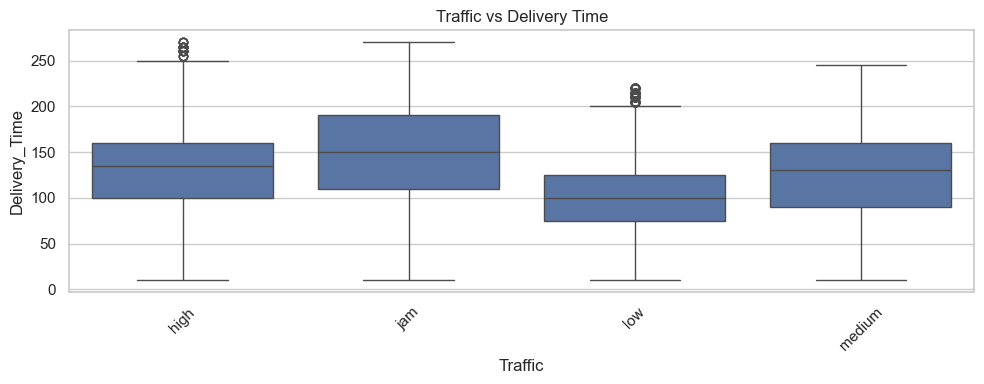

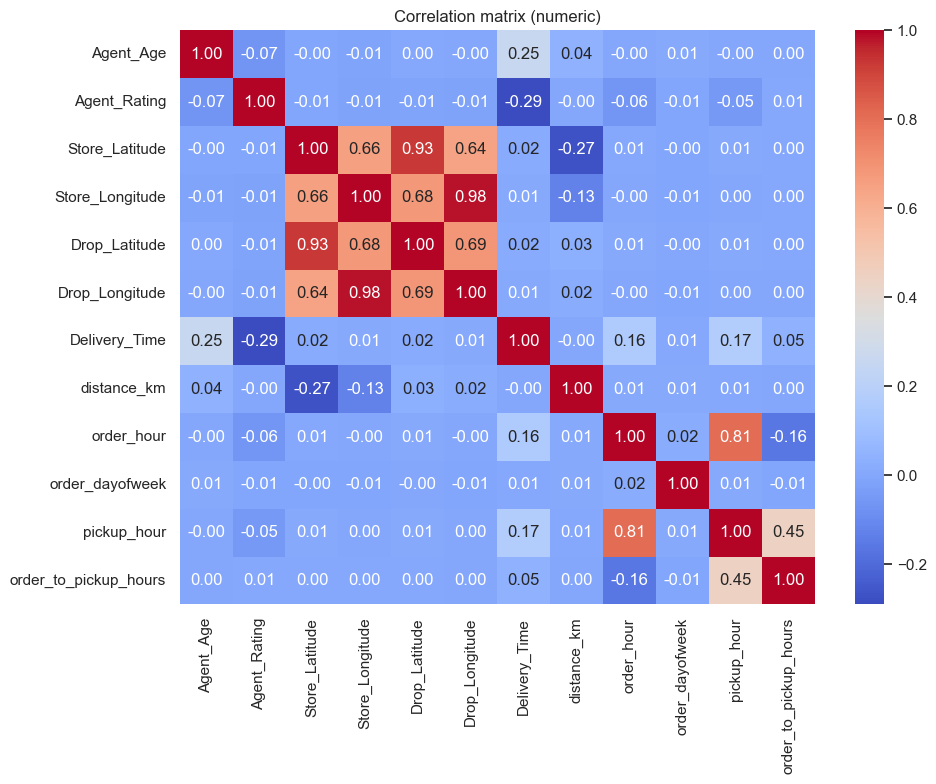

In [8]:
# Cell 5: EDA visuals
df = pd.read_csv(DATA_PROCESSED)

plt.figure(figsize=(8,4))
sns.histplot(df['Delivery_Time'], bins=40, kde=True)
plt.title("Delivery Time Distribution (hours)")
plt.xlabel("Delivery_Time (hours)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.scatterplot(x='distance_km', y='Delivery_Time', data=df, alpha=0.5)
plt.title("Distance vs Delivery Time")
plt.tight_layout()
plt.show()

if 'Traffic' in df.columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(x='Traffic', y='Delivery_Time', data=df)
    plt.title("Traffic vs Delivery Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# correlation heatmap for numeric features
num_cols = df.select_dtypes(include=['float64','int64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix (numeric)")
plt.tight_layout()
plt.show()


In [9]:
# Cell 6: prepare features
df = pd.read_csv(DATA_PROCESSED)

# candidate numeric & categorical features (only keep those present)
numeric_features = ['distance_km','order_hour','order_dayofweek','pickup_hour','order_to_pickup_hours','Agent_Age','Agent_Rating']
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [c for c in ['Weather','Traffic','Vehicle','Area','Category'] if c in df.columns]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

X = df[numeric_features + categorical_features]
y = df['Delivery_Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Numeric features used: ['distance_km', 'order_hour', 'order_dayofweek', 'pickup_hour', 'order_to_pickup_hours', 'Agent_Age', 'Agent_Rating']
Categorical features used: ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
Train shape: (34991, 12) Test shape: (8748, 12)


In [11]:
# Cell 7: preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')


In [14]:
# Cell 8: training + mlflow logging
mlflow.set_experiment("Amazon_Delivery_Time_Prediction")

models = {
    "linear": LinearRegression(),
    "random_forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "xgboost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1, objective='reg:squarederror')
}

best_rmse = float("inf")
best_pipe = None
best_name = None

for name, estimator in models.items():
    with mlflow.start_run(run_name=name):
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("estimator", estimator)])
        pipe.fit(X_train, y_train)

        preds = pipe.predict(X_test)
        rmse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_param("model", name)
        if name == 'random_forest':
            mlflow.log_param("n_estimators", estimator.n_estimators)
        if name == 'xgboost':
            mlflow.log_param("n_estimators", estimator.n_estimators)
            mlflow.log_param("learning_rate", estimator.learning_rate)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # log the full sklearn pipeline
        mlflow.sklearn.log_model(pipe, name="model")

        print(f"{name} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_pipe = pipe
            best_name = name

print("Best model:", best_name, "RMSE:", best_rmse)


2025/09/29 13:57:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


linear | RMSE: 1100.4296 | MAE: 26.1119 | R2: 0.5869


2025/09/29 14:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


random_forest | RMSE: 499.0097 | MAE: 17.1403 | R2: 0.8127


2025/09/29 14:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgboost | RMSE: 483.2363 | MAE: 17.1418 | R2: 0.8186
Best model: xgboost RMSE: 483.236328125


In [15]:
# Cell 9: save best model
if best_pipe is None:
    raise RuntimeError("No model trained. Check previous cell.")

best_path = os.path.join(MODEL_DIR, f"best_model_{best_name}.joblib")
joblib.dump(best_pipe, best_path)
print("Saved best model to:", best_path)


Saved best model to: models\best_model_xgboost.joblib


RMSE: 483.236328125
MAE: 17.141756057739258
R2: 0.8186007738113403


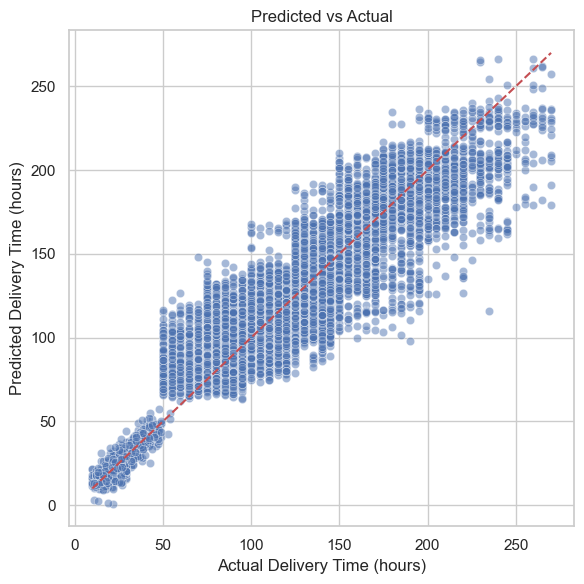

In [17]:
# Cell 10: evaluate saved model on test set
loaded = joblib.load(best_path)
preds = loaded.predict(X_test)

print("RMSE:", mean_squared_error(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("R2:", r2_score(y_test, preds))

# scatter predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Delivery Time (hours)")
plt.ylabel("Predicted Delivery Time (hours)")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()


In [18]:
# Cell 11: sample prediction - build one input row
sample = X_test.iloc[[0]].copy()
print("Input sample:")
display(sample)

pred_val = loaded.predict(sample)[0]
print(f"Predicted delivery time: {pred_val:.2f} hours")
print("Actual:", float(y_test.iloc[0]))


Input sample:


,distance_km,order_hour,order_dayofweek,pickup_hour,order_to_pickup_hours,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Category
20794,7.790439,17.0,5.0,17,0.25,29,4.9,stormy,medium,motorcycle,metropolitian,skincare


Predicted delivery time: 113.90 hours
Actual: 145.0
